In [1]:
! pip install psycopg2
! pip install sklearn
! pip install cachetools

import psycopg2

import numpy as np

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

from cachetools import cached, TTLCache

In [2]:
device_id = "iskra"

In [3]:
def create_connection():
    dbname = 'postgres'
    user = 'postgres'
    password = 'postgres'
    host = '192.168.11.7'
    return psycopg2.connect(dbname=dbname, user=user, password=password, host=host)

In [4]:
@cached(cache=TTLCache(maxsize=32, ttl=60))
def fetch_aggregated_calibration_data(ignore_outliers = True):
	with create_connection() as connection:
		connection = create_connection()
		with connection.cursor() as cursor:
			cursor.execute(f"""SELECT temperature, humidity, AVG(r0) as r0 
				FROM sensor_calibration_data
				WHERE device_id = %s AND is_invalid = false {'AND is_outlier = false ' if ignore_outliers else ''}
				GROUP BY temperature, humidity """, (device_id,))
			return np.array(cursor.fetchall(), dtype=float)

In [5]:
@cached(cache=TTLCache(maxsize=32, ttl=60))
def fetch_calibration_data(include_ids = False, ignore_outliers = True):
	with create_connection() as connection:
		connection = create_connection()
		with connection.cursor() as cursor:
			cursor.execute(f"""SELECT {' id, ' if include_ids else ''} temperature, humidity, r0 
				FROM sensor_calibration_data 
				WHERE device_id = %s AND is_invalid = false {'AND is_outlier = false' if ignore_outliers else ''} """, (device_id,))
			return np.array(cursor.fetchall(), dtype=float)

In [6]:
def buildModel(degree, train):
    pipe = make_pipeline(StandardScaler(), PolynomialFeatures(degree), LinearRegression())
    pipe.fit(train[:,:-1], train[:,-1])
    return pipe

In [7]:
def invalidate_out_of_bounds_values():
    with create_connection() as connection:
        connection = create_connection()
        with connection.cursor() as cursor:
            sqlCommand = """
            UPDATE sensor_calibration_data
            SET is_invalid = true
            WHERE device_id = %s AND
            ( temperature < -40 OR temperature > 80 OR humidity < 0 OR humidity > 100 OR uptime < '20 minutes' )
            """
            cursor.execute(sqlCommand, (device_id,))
            connection.commit()

def flag_outliers(ids):
    with create_connection() as connection:
        connection = create_connection()
        with connection.cursor() as cursor:
            sqlCommand = """
            UPDATE sensor_calibration_data
            SET is_outlier = true
            WHERE device_id = %s AND id IN %s
            """
            cursor.execute(sqlCommand, (device_id, tuple(ids)))
            connection.commit()

def invalidate_loners():
    with create_connection() as connection:
        connection = create_connection()
        with connection.cursor() as cursor:
            sqlCommand = """
            WITH data AS (
                SELECT row_number() OVER () row_id, id, received_at
                FROM sensor_calibration_data
                WHERE device_id = %s
                ORDER BY received_at
            ),
            tails AS (
                SELECT n.id
                FROM data n
                LEFT JOIN data p ON (n.row_id = p.row_id + 1 AND n.received_at - p.received_at < interval '5 second')
                WHERE p.id IS NULL
            ),
            heads AS (
                SELECT p.id
                FROM data p
                LEFT JOIN data n ON (n.row_id = p.row_id + 1 AND n.received_at - p.received_at < interval '5 second')
                WHERE n.id IS NULL
            ),
            loners AS (
                SELECT t.id
                FROM tails t
                JOIN heads h ON (t.id = h.id)
            )
            UPDATE sensor_calibration_data
            SET is_outlier = true
            WHERE id IN (SELECT id FROM loners)
            """
            cursor.execute(sqlCommand, (device_id,))
            connection.commit()

@cached(cache=TTLCache(maxsize=32, ttl=60))
def fetch_dr0(ignore_outliers = True):
    with create_connection() as connection:
        connection = create_connection()
        with connection.cursor() as cursor:
            sqlCommand = f"""
            WITH data AS (
                SELECT row_number() OVER () row_id, id, r0, received_at
                FROM sensor_calibration_data
                WHERE device_id = %s AND is_invalid = false {'AND is_outlier = false' if ignore_outliers else ''}
                ORDER BY received_at
            )
            SELECT p.id, n.id, (n.r0 - p.r0)/(EXTRACT(EPOCH FROM (n.received_at - p.received_at))) as dr0
            FROM data n
            JOIN data p ON (n.row_id = p.row_id + 1 AND n.received_at - p.received_at < interval '5 second')
            """
            cursor.execute(sqlCommand, (device_id,))
            return np.array(cursor.fetchall(), dtype=float)

def mark_outliers_by_rate_of_change():
    data = fetch_dr0(ignore_outliers = False)

    dr0 = data[:,2].reshape(-1, 1)
    scaler = StandardScaler()
    scaler.fit(dr0)
    dr0_std = scaler.transform(dr0).reshape(-1)

    outliers_mask = (dr0_std < -3) | (dr0_std > 3)
    outliers_id = data[outliers_mask][:, :2].astype(int).flatten().tolist()

    if outliers_id:
        flag_outliers(outliers_id)

def mark_outliers_by_model():
    data = fetch_calibration_data(include_ids=True, ignore_outliers=False)
    model = buildModel(2, data[:,1:])
    predicted_r0 = model.predict(data[:, 1:3])
    error = (data[:,3] - predicted_r0).reshape(-1, 1)
    
    scaler = StandardScaler()
    scaler.fit(error)
    std_error = scaler.transform(error).reshape(-1)

    outliers_mask = (std_error < -5) | (std_error > 5)

    outliers_id = data[outliers_mask, 0].astype(int).flatten().tolist()
    if outliers_id:
        flag_outliers(outliers_id)

def clean_up():
    invalidate_out_of_bounds_values()
    mark_outliers_by_rate_of_change()
    mark_outliers_by_model()

In [8]:
clean_up()

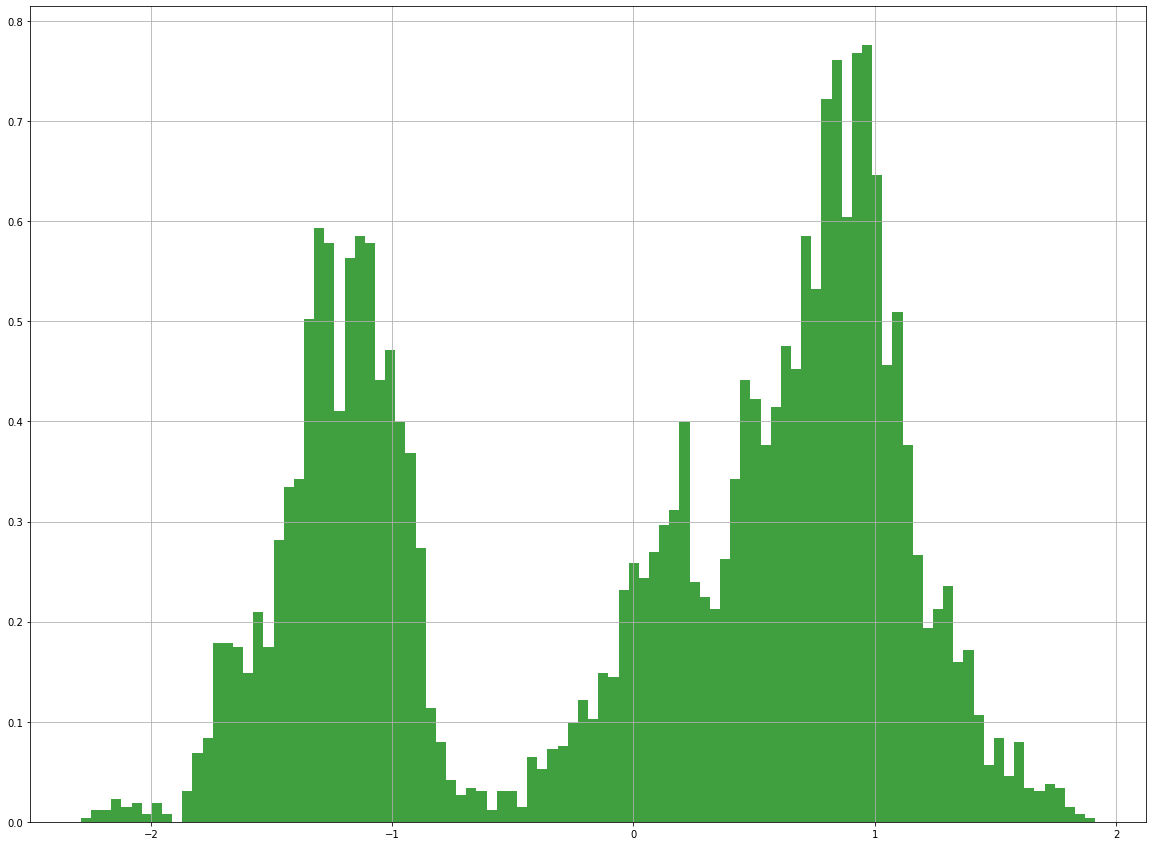

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 15))

data = fetch_aggregated_calibration_data(ignore_outliers=True)
x = data[:,2].reshape(-1, 1)

scaler = StandardScaler()
scaler.fit(x)
x = scaler.transform(x)

# the histogram of the data
n, bins, patches = plt.hist(x, 100, density=True, facecolor='g', alpha=0.75)

plt.grid(True)
plt.show()

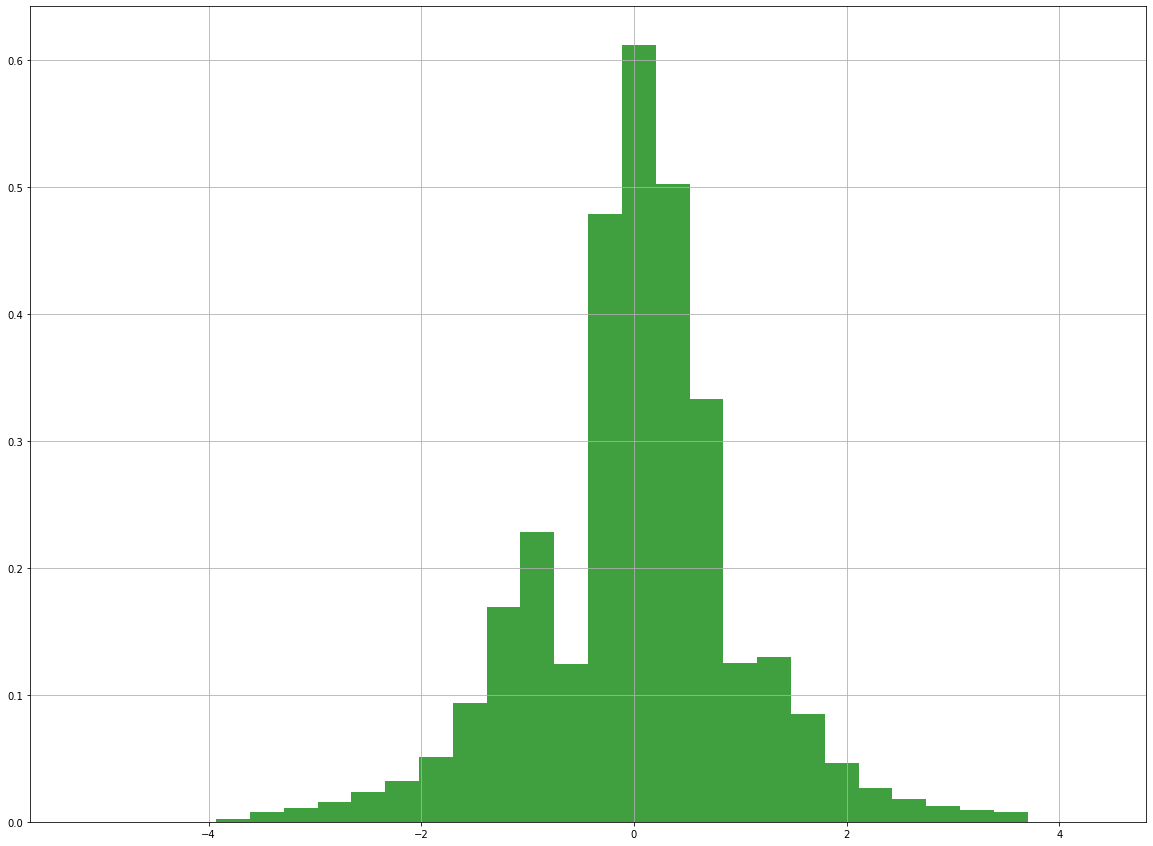

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 15))

data = fetch_dr0(ignore_outliers=True)
x = data[:,2].reshape(-1, 1)

scaler = StandardScaler()
scaler.fit(x)
x = scaler.transform(x)

# the histogram of the data
n, bins, patches = plt.hist(x, 30, density=True, facecolor='g', alpha=0.75)

plt.grid(True)
plt.show()

In [11]:
def runExperiment(degree, aggregated_data, ignore_outliers):
    data = fetch_aggregated_calibration_data(ignore_outliers) if aggregated_data else fetch_calibration_data(ignore_outliers)
    train, test = train_test_split(data)    
    pipe = buildModel(degree, train)
    train_score = pipe.score(train[:,:-1], train[:,-1])
    test_score = pipe.score(test[:,:-1], test[:,-1])
    return (train_score, test_score)

In [22]:
param_grid = {'degree': [1, 2, 3], 'aggregated_data': [True], 'ignore_outliers': [True, False] }

results = [(test_case, runExperiment(**test_case))for test_case in ParameterGrid(param_grid)]
results.sort(key=lambda p: p[1][1], reverse=True)
for result in results:
        print(result)

({'aggregated_data': True, 'degree': 3, 'ignore_outliers': True}, (0.8164819846998943, 0.8018453369468657))
({'aggregated_data': True, 'degree': 2, 'ignore_outliers': True}, (0.7560124549125937, 0.7597469566954009))
({'aggregated_data': True, 'degree': 1, 'ignore_outliers': True}, (0.7241389057686669, 0.7378440225951663))
({'aggregated_data': True, 'degree': 3, 'ignore_outliers': False}, (0.7413041347722371, 0.7057939164632079))
({'aggregated_data': True, 'degree': 1, 'ignore_outliers': False}, (0.6446027322431929, 0.6692489349507872))
({'aggregated_data': True, 'degree': 2, 'ignore_outliers': False}, (0.6565064753290851, 0.6457792674113512))


In [13]:
data = fetch_calibration_data(include_ids=True, ignore_outliers=False)
model = buildModel(2, data[:,1:])
predicted_r0 = model.predict(data[:, 1:3])
error = (data[:,3] - predicted_r0).reshape(-1, 1)

scaler = StandardScaler()
scaler.fit(error)
std_error = scaler.transform(error).reshape(-1)

outliers_mask = (std_error < -5) | (std_error > 5)
std_error = std_error[~outliers_mask]

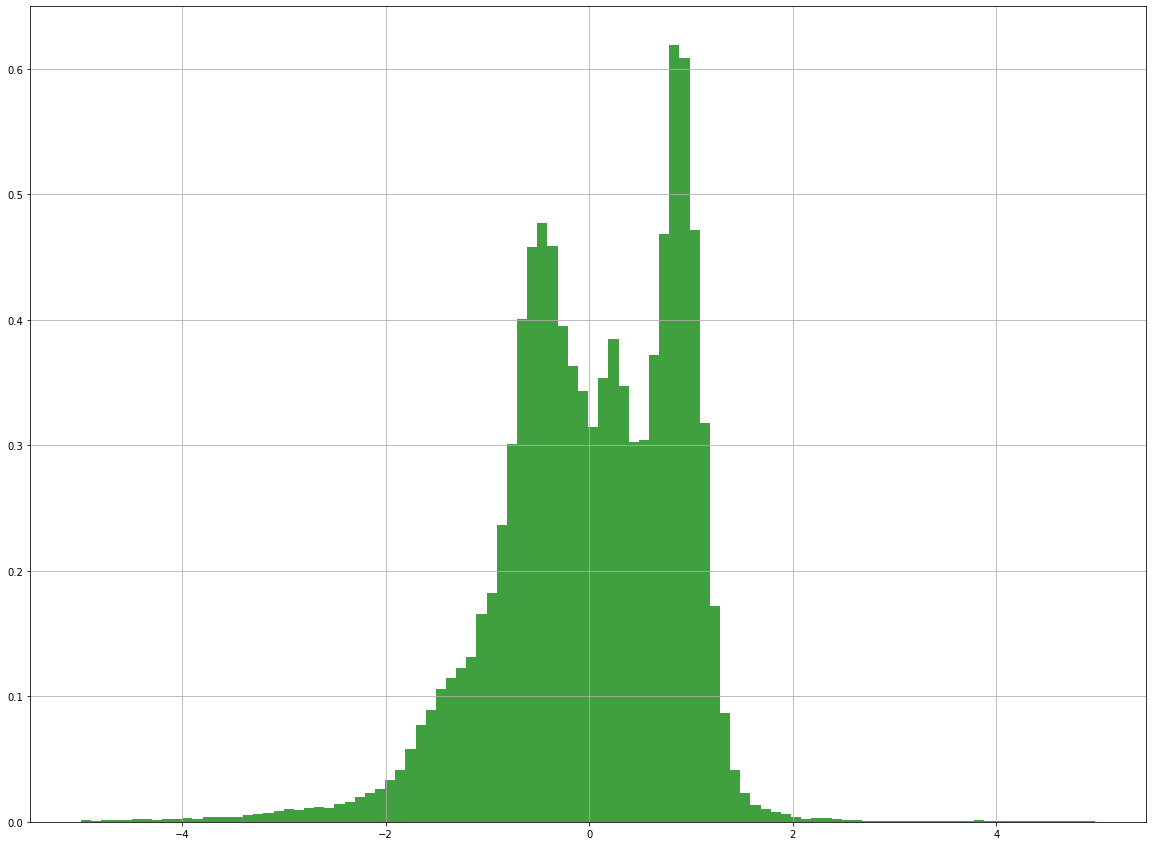

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 15))

x = std_error.reshape(-1, 1)

# the histogram of the data
n, bins, patches = plt.hist(x, 100, density=True, facecolor='g', alpha=0.75)

plt.grid(True)
plt.show()

In [29]:
plot_data = fetch_aggregated_calibration_data(ignore_outliers=True)

In [30]:
model = buildModel(2, plot_data)
model.predict(np.array([[23, 57.2]]))

array([79.53968655])

(467, 138)
(64446, 2)


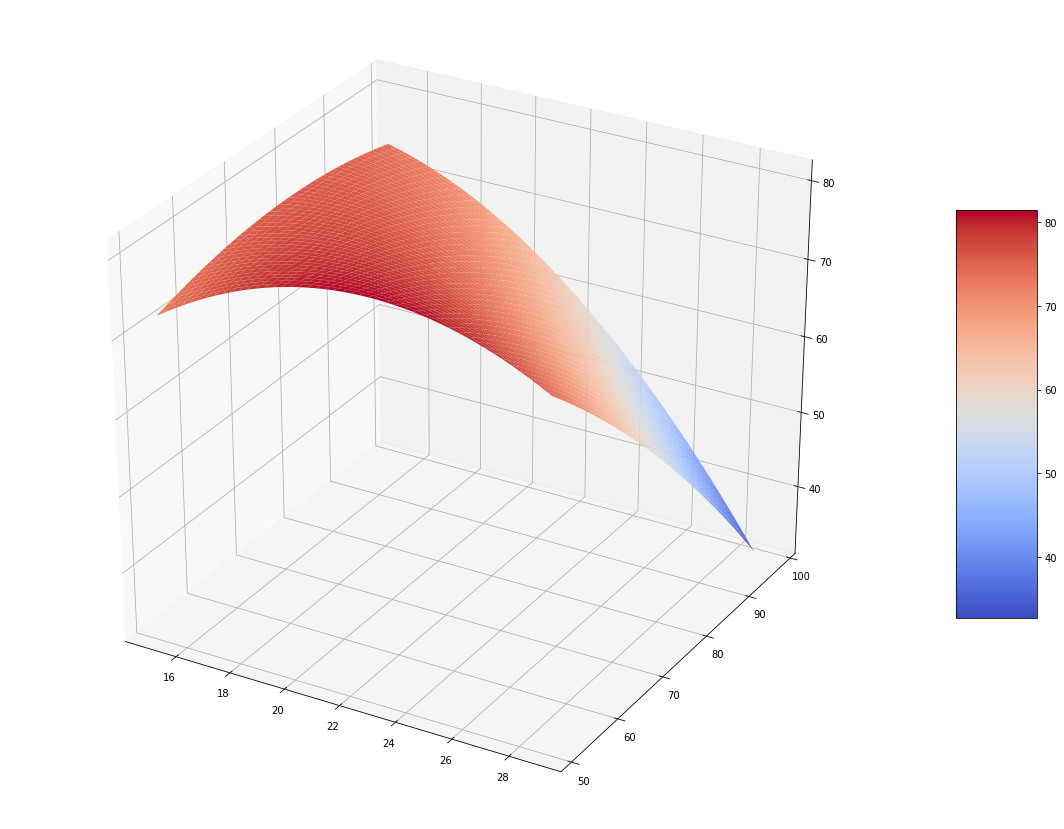

In [31]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import numpy as np

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
fig.set_size_inches(20, 15)

min_temperature = plot_data[:,0].min()
max_temperature = plot_data[:,0].max()
min_humidity = plot_data[:,1].min()
max_humidity = plot_data[:,1].max()

# Make data.
X = np.arange(min_temperature * 0.95, max_temperature * 1.05, 0.1)
Y = np.arange(min_humidity * 0.95, max_humidity * 1.05, 0.1)
#print(X, Y)
X, Y = np.meshgrid(X, Y)

print(X.shape)
XYpairs = np.dstack([X, Y]).reshape(-1, 2)
print(XYpairs.shape)
Z = model.predict(XYpairs)
Z = Z.reshape(X.shape)

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=True)


# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

#plot_dots = plot_data
#print(plot_dots.shape)
#ax.scatter(plot_dots[:,0], plot_dots[:,1], plot_dots[:,2], cmap=cm.coolwarm )

plt.show()

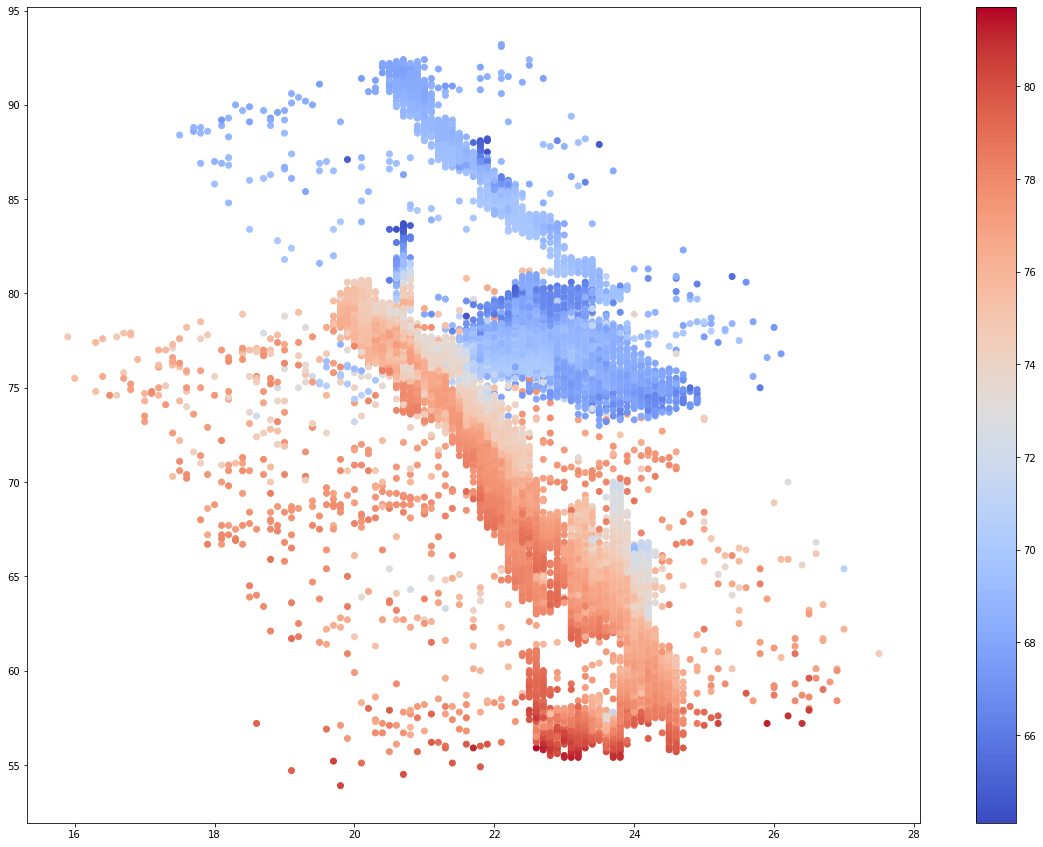

In [32]:
plt.figure(figsize=(20, 15))

zdata = plot_data[:,-1]
xdata = plot_data[:, 0]
ydata = plot_data[:, 1]
scatter = plt.scatter(xdata, ydata, c=zdata, cmap=cm.coolwarm);
plt.colorbar(scatter)
#fig.colorbar(surf, shrink=0.5, aspect=5)
#type(scatter)